In [69]:
INPUT_FILES = {
    "01": "../scripts/data/MMS/tid-10142-actives_100mms_sub-moedescriptors.tsv",
    "02": "../scripts/data/MMS/tid-10142-actives_154mms_sub-moedescriptors.tsv",
    "03": "../scripts/data/MMS/tid-10280-actives_90mms_sub-moedescriptors.tsv",
    "04": "../scripts/data/MMS/tid-10627-actives_106mms_sub-moedescriptors.tsv",
    "05": "../scripts/data/MMS/tid-129-actives_462mms_sub-moedescriptors.tsv",
    "06": "../scripts/data/MMS/tid-137-actives_49mms_sub-moedescriptors.tsv",
    "07": "../scripts/data/MMS/tid-194-actives_232mms_sub-moedescriptors.tsv",
    "08": "../scripts/data/MMS/tid-20174-actives_26mms_sub-moedescriptors.tsv",
    "09": "../scripts/data/MMS/tid-278-actives_20mms_sub-moedescriptors.tsv",
    "10": "../scripts/data/MMS/tid-280-actives_417mms_sub-moedescriptors.tsv",
    "11": "../scripts/data/MMS/tid-8-actives_44mms_sub-moedescriptors.tsv",
    "12": "../scripts/data/MMS/tid-8-actives_49mms_sub-moedescriptors.tsv",
}

MMS_COLUMNS = ['chembl-id', 'pot.(log,Ki)', 'pot.(nMol,Ki)', 'aromatic_smiles', 'non_stereo_aromatic_smieles',
               'all-chembl-ids', 'no.-meas.', 'pref_name', 'accession', 'natoms',
               'core', 'sub', 'sub_carbon_replacement', 'arorings', 'a_acc',
               'a_don', 'a_heavy', 'logP(o/w)', 'RBC', 'rings',
               'TPSA', 'vdw_vol', 'Weight']
MMS_COLRENAME = {"arorings": "arings", "a_acc": "acc", "a_don": "don", "logP(o/w)": "logp", "RBC": "rbc",
                 "TPSA": "tpsa", "Weight": "mw", "pot.(log,Ki)":"pot"}
                 # RBC: Rotatable Bond Counts
MMS_FEATLIST = {'10': ["arings", "acc", "don", "a_heavy", "logp", "rbc", "rings", "tpsa", "vdw_vol", "mw"],
                '7' : ["arings", "acc", "don", "logp", "rbc", "tpsa", "mw"],
                '4' : ["logp", "rbc", "tpsa", "mw"],}
MMS_PROPERTY = "pot"

In [74]:
from figp.deap_based_func_node import Node_space, NumpyBasedFunction
from figp.deap_based_FGP_NLS import optimize_equations

from deap import gp, base, creator
import random
 
def setup_toolbox_sympyspace(x_, random_state):
    
    """set up premitive set"""
    _can_use_func = ['add', 'sub', 'mul', 'div', 'sqrt', 'square', 'cube', 'ln', 'exp', 'protected_division', 'protected_ln', 'protected_sqrt']
    sympy_space = Node_space(x_, func_list=_can_use_func)
    const_range     = (-1, 1)
    # print(function_set)

    """set up function space"""
    function_set  = ['add', 'sub', 'mul', 'div', 'sqrt', 'square', 'cube', 'ln', 'exp']
    
    """random seed"""
    random.seed(random_state)

    pset = gp.PrimitiveSet("MAIN", x_.shape[1])

    for i, x_name in enumerate(x_.columns):
        p = {'ARG{}'.format(i):f'{x_name}'}
        pset.renameArguments(**p)

    if 'add' in function_set: pset.addPrimitive(NumpyBasedFunction.add, 2)
    if 'sub' in function_set: pset.addPrimitive(NumpyBasedFunction.sub, 2)
    if 'mul' in function_set: pset.addPrimitive(NumpyBasedFunction.mul, 2)
    if 'div' in function_set: pset.addPrimitive(NumpyBasedFunction.div, 2)
    if 'ln'  in function_set: pset.addPrimitive(NumpyBasedFunction.ln, 1)
    if 'sqrt' in function_set: pset.addPrimitive(NumpyBasedFunction.sqrt, 1)
    if 'square' in function_set: pset.addPrimitive(NumpyBasedFunction.square, 1)
    if 'cube' in function_set: pset.addPrimitive(NumpyBasedFunction.cube, 1)
    if 'exp' in function_set: pset.addPrimitive(NumpyBasedFunction.exp, 1)
    if 'protected_division' in function_set: pset.addPrimitive(NumpyBasedFunction.protected_division, 2)
    if 'protected_sqrt' in function_set: pset.addPrimitive(NumpyBasedFunction.protected_sqrt, 1)
    if 'protected_ln' in function_set: pset.addPrimitive(NumpyBasedFunction.protected_ln, 1)

    # add initial constant to be optimized
    n_c_node = 1
    add_n_c_node = 0
    _count = 0
    while add_n_c_node < n_c_node:
        try:
            pset.addEphemeralConstant(f'c_node_{_count}', lambda: random.uniform(const_range[0],const_range[1]))
            add_n_c_node += 1
            _count += 1
        except:
            _count += 1
            pass

    print("Prims Count:", pset.prims_count)

    """set up toolbox"""
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox_ = base.Toolbox()
    # toolbox_.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2) # gp.genHalfAndHalf https://deap.readthedocs.io/en/master/api/tools.html#deap.gp.genHalfAndHalf
    toolbox_.register("compile", gp.compile, pset=pset)

    return toolbox_, sympy_space


def d2_filter_optimize_routine(expr, x_, y_, toolbox_):
    """D2_filter optimize routine"""
    
    x0_index_list = random.sample(range(x_.shape[0]), k=5)
    # y_domain_min, y_domain_max = min(y_), max(y_)
    _range = (y_.max() - y_.min())
    y_domain_min, y_domain_max = y_.min()-0.1*_range, y_.max()+0.1*_range

    minmax_pool = []
    n_samples = x_.shape[0]
    x0_index_list = random.sample(range(n_samples), k=5)
    for Xnum in x0_index_list:

        # print(x_.iloc[Xnum].values)
        # print(toolbox_.compile(expr)(*x_.iloc[Xnum].values))

        minmax_pool.extend(
            optimize_equations(
                expr, 
                x_, 
                Xnum, 
                toolbox_.compile,
                ))
    y_min = min(minmax_pool)
    y_max = max(minmax_pool)
    print("expr:", str(expr))
    print("min:", y_min, ">? min(domain):", y_domain_min)
    print("max:", y_max, "<? max(domain):", y_domain_max)

    if ((y_domain_min <= y_min) & (y_max <= y_domain_max)):
        print(f'=>>D2-pass{(y_min, y_max)}-n{len(set(minmax_pool))}')
    else:
        print(f'=>>D2-error{(y_min, y_max)}-n{len(set(minmax_pool))}')

    # optimize_equations(expr, x_, sympy_space, compiler='numpy')
    # def optimize_equations(ind, X, Xnum, compiler):


In [77]:
import pandas as pd
import numpy as np
import json

"""Load MMS data"""
file = INPUT_FILES["09"]
mms_featlist = MMS_FEATLIST["10"] # "7", "4"

df = pd.read_table(file, index_col=0)
df = df.rename(columns=MMS_COLRENAME)
print(df.columns)
print(file, df["core"].iloc[0])
ndata = len(df.index)

x_ = df.loc[:, mms_featlist]
y_ = df.loc[:, MMS_PROPERTY]
# x_ = pd.DataFrame(np.array([[idx/10 for idx in range(20)]]).T, columns=["x"])
# y_ = pd.DataFrame(np.array([[(idx/10)+random.random()*(idx/10)**2 for idx in range(20)]]).T, columns=["y"])
# display(x_)
# display(y_)

"""Calc bounds and set up x_toplot(mid point)"""
bounds = [(mn - (mx - mn) *0.1, mx + (mx - mn) *0.1) for mn, mx in zip(x_.min(), x_.max())]
print([f"{col}:{bnd}" for col,bnd in zip(x_.columns, bounds)])

x_toplot = pd.Series([(mx+mn)/2 for mn, mx in bounds], index=x_.columns)
display(x_toplot)

"""SETUP DEAP_TOOLBOX and SYMPY_SPACE """
random_state = 4
toolbox_, sympy_space = setup_toolbox_sympyspace(x_, random_state=random_state)

"""expr json files"""
json_files = ["FVD_D5_F10_09_4_1.json",
              "FVD2D2_D5_F10_09_0_4.json",
              "FVD2_D5_F10_09_0_1.json"]
# json_file = "FVD_D5_F10_09_4_1.json"
# json_file = "FVD2D2_D5_F10_09_0_4.json"
# json_file = "FVD2_D5_F10_09_0_1.json"

exprs = {}
for json_file in json_files:
    _method = json_file.split("_")[0].replace("FVD", "FIGP").replace("2D2", "2(D2)")
    print(_method)

    expr_json = None
    with open(json_file, "r") as f:
        expr_json = json.load(f)

    print(expr_json)
    expr = eval(expr_json["expr"], sympy_space.Nspace())
    print(expr)

    exprs[_method] = expr

    # str_expr = "add(x, mul(x, x))"
    # expr = eval(str_expr, sympy_space.Nspace())

    # expr_ = toolbox_.expr()
    # print(expr_)
    # ind = creator.Individual(expr_)
    # # ind = creator.Individual(gp.genHalfAndHalf(pset, min_=1, max_=2))
    # expr = creator.Individual(ind)
    # print("expr type:", type(expr))

    d2_filter_optimize_routine(expr, x_, y_, toolbox_)
    print("")



Index(['chembl-id', 'pot', 'pot.(nMol,Ki)', 'aromatic_smiles',
       'non_stereo_aromatic_smieles', 'all-chembl-ids', 'no.-meas.',
       'pref_name', 'accession', 'natoms', 'core', 'sub',
       'sub_carbon_replacement', 'arings', 'acc', 'don', 'a_heavy', 'logp',
       'rbc', 'rings', 'tpsa', 'vdw_vol', 'mw'],
      dtype='object')
../scripts/data/MMS/tid-278-actives_20mms_sub-moedescriptors.tsv CCCn1c(=O)c2nc(-c3cnn(C[*:1])c3)[nH]c2n(CCC)c1=O
['arings:(0.9, 2.1)', 'acc:(-0.2, 2.2)', 'don:(-0.1, 1.1)', 'a_heavy:(7.5, 13.5)', 'logp:(1.37782401, 4.18793589)', 'rbc:(-0.2, 2.2)', 'rings:(0.9, 2.1)', 'tpsa:(-3.8919998000000002, 42.8119978)', 'vdw_vol:(127.55184299999999, 226.354767)', 'mw:(95.5275, 223.2135)']


arings       1.500000
acc          1.000000
don          0.500000
a_heavy     10.500000
logp         2.782880
rbc          1.000000
rings        1.500000
tpsa        19.459999
vdw_vol    176.953305
mw         159.370500
dtype: float64

Prims Count: 9
FIGP
{'expr': 'sub(div(sub(-0.4043800248232919, div(-0.4023234588720152, arings)), sub(div(vdw_vol, -51.01002904397206), sub(logp, 5.289756003076655))), add(mul(add(mw, tpsa), -0.022691408552163193), add(-9.68981455330568, mul(a_heavy, 0.591070605083315))))', 'use_X': ['arings', 'vdw_vol', 'logp', 'mw', 'tpsa', 'a_heavy']}
-0.591070605083315*a_heavy + 0.0226914085521632*mw + 0.0226914085521632*tpsa + (-0.404380024823292 + 0.402323458872015/arings)/(-logp - 0.0196039880537604*vdw_vol + 5.28975600307666) + 9.68981455330568
expr: -0.591070605083315*a_heavy + 0.0226914085521632*mw + 0.0226914085521632*tpsa + (-0.404380024823292 + 0.402323458872015/arings)/(-logp - 0.0196039880537604*vdw_vol + 5.28975600307666) + 9.68981455330568
min: -129022428.06523187 >? min(domain): 4.952
max: 23506796.243615035 <? max(domain): 9.368
=>>D2-error(-129022428.06523187, 23506796.243615035)-n10

FIGP2(D2)
{'expr': 'sub(add(mul(cube(-0.010390932804188839), exp(a_heavy)), 7.205452305936281), div

In [78]:
print(expr)

def func_apply_expr_xconst(expr, logps, xconst):
    arr_ = np.array([])
    for logp_ in logps:
        xconst["logp"] = logp_
        """insert numpy new raw"""
        arr_ = np.insert(arr_, len(arr_), toolbox_.compile(expr)(*xconst.values))

    return arr_

print(func_apply_expr_xconst(expr, np.linspace(-1, 5, 10), x_toplot))


(-0.144404465355574 - 0.00125005057340645*tpsa/logp)*(a_heavy - 58.8146826663119)
[ 5.80155377  3.45094948 10.50276235  8.15215806  7.68203721  7.48055684
  7.3686233   7.29739287  7.24807949  7.21191635]


figps_mms09.png


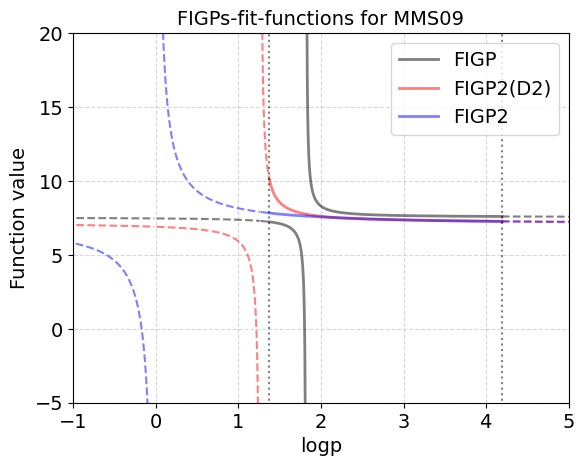

In [94]:
import matplotlib.pyplot as plt

# def f_mss09_figp2(logp_):
#     return -0.328581587123305*1.0/(1.26536521388416 - logp_) - 1.12192444063579e-6*np.exp(10.5) + 7.20545230593628

"""plot an expression"""
def plot_expr_logp(_method, expr):

    # range_logp = [1.37782401, 4.18793589]

    xs1 = np.linspace(-4, 1.26, 1000)
    xs2 = np.linspace(1.27, 1.37782401, 100)
    xs3, xs4 = None, None
    if _method == "FIGP":
        xs3 = np.linspace(1.37782401, 1.81, 100)
        xs4 = np.linspace(1.83, 4.18793589, 900)
    else:
        xs3 = np.linspace(1.37782401, 1.80, 100)
        xs4 = np.linspace(1.85, 4.18793589, 900)

    xs5 = np.linspace(4.18793589, 5, 300)
    # print(f_mss09_figp2(xs1))

    plt.plot(xs1, func_apply_expr_xconst(expr, xs1, x_toplot), linestyle="--", alpha=0.5, color="black")
    plt.plot(xs2, func_apply_expr_xconst(expr, xs2, x_toplot), linestyle="--", alpha=0.5, color="black")
    plt.plot(xs3, func_apply_expr_xconst(expr, xs3, x_toplot), linestyle="solid", alpha=0.5, color="black", linewidth=3)
    plt.plot(xs4, func_apply_expr_xconst(expr, xs4, x_toplot), linestyle="solid", alpha=0.5, color="black", linewidth=3)
    plt.plot(xs5, func_apply_expr_xconst(expr, xs5, x_toplot), linestyle="--", alpha=0.5, color="black")
    # plt.plot(xs2, f_mss09_figp2(xs2), linestyle="--", alpha=0.5, color="black")
    # plt.plot(xs3, f_mss09_figp2(xs3), linestyle="solid", alpha=0.5, color="black", linewidth=3)
    # plt.plot(xs4, f_mss09_figp2(xs4), linestyle="--", alpha=0.5, color="black")
    plt.xlabel(r"logp", fontsize=14)
    plt.ylabel(r"Function value", fontsize=14)
    plt.vlines([1.37782401, 4.18793589], -50, 50, linestyles="dotted", alpha=0.5, color="black")
    plt.xlim(-2, 5)
    plt.ylim(-5, 20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.title(r"$0.3acc/(1.3 - logP) - 1.1 \cdot 10^{-6} e^{a_{heavy}} + 7.2$")
    # plt.title("FIGP2-fit-function for MMS09", fontsize=14)
    plt.title(f"{_method}-fit-function for MMS09", fontsize=14)
    plt.grid(linestyle="--", alpha=0.5)
    fig_file = f"{_method.replace('(D2)', 'd2').lower()}_mms09.png"
    print(fig_file)
    plt.savefig(fig_file, dpi=300, bbox_inches="tight")
    plt.show()


"""plot expressions"""
def plot_exprs_logp(exprs):

    colors = ["black", "red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan", "magenta"]
    cnt = 0
    for _method, expr in exprs.items():
        # range_logp = [1.37782401, 4.18793589]

        xs0 = np.linspace(-4, -0.015, 800)
        xs1 = np.linspace(0.015, 1.26, 200)
        xs2 = np.linspace(1.27, 1.37782401, 100)
        xs3, xs4 = None, None
        if _method == "FIGP":
            xs3 = np.linspace(1.37782401, 1.81, 100)
            xs4 = np.linspace(1.83, 4.18793589, 900)
        else:
            xs3 = np.linspace(1.37782401, 1.815, 100)
            xs4 = np.linspace(1.845, 4.18793589, 900)

        xs5 = np.linspace(4.18793589, 5, 300)
        # print(f_mss09_figp2(xs1))

        plt.plot(xs0, func_apply_expr_xconst(expr, xs0, x_toplot), linestyle="--", alpha=0.5, color=colors[cnt])
        plt.plot(xs1, func_apply_expr_xconst(expr, xs1, x_toplot), linestyle="--", alpha=0.5, color=colors[cnt])
        plt.plot(xs2, func_apply_expr_xconst(expr, xs2, x_toplot), linestyle="--", alpha=0.5, color=colors[cnt])
        plt.plot(xs3, func_apply_expr_xconst(expr, xs3, x_toplot), linestyle="solid", alpha=0.5, color=colors[cnt], linewidth=2, label=_method)
        plt.plot(xs4, func_apply_expr_xconst(expr, xs4, x_toplot), linestyle="solid", alpha=0.5, color=colors[cnt], linewidth=2)
        plt.plot(xs5, func_apply_expr_xconst(expr, xs5, x_toplot), linestyle="--", alpha=0.5, color=colors[cnt])
        # plt.plot(xs2, f_mss09_figp2(xs2), linestyle="--", alpha=0.5, color="black")
        # plt.plot(xs3, f_mss09_figp2(xs3), linestyle="solid", alpha=0.5, color="black", linewidth=3)
        # plt.plot(xs4, f_mss09_figp2(xs4), linestyle="--", alpha=0.5, color="black")

        cnt += 1
        
    plt.legend(fontsize=14)
    plt.xlabel(r"$logP$", fontsize=14)
    plt.ylabel(r"Function value", fontsize=14)
    plt.vlines([1.37782401, 4.18793589], -50, 50, linestyles="dotted", alpha=0.5, color="black")
    plt.xlim(-1, 5)
    plt.ylim(-5, 20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.title(r"$0.3acc/(1.3 - logP) - 1.1 \cdot 10^{-6} e^{a_{heavy}} + 7.2$")
    # plt.title("FIGP2-fit-function for MMS09", fontsize=14)


    plt.title(f"FIGPs-fit-functions for MMS09", fontsize=14)
    plt.grid(linestyle="--", alpha=0.5)
    fig_file = f"figps_mms09.png"
    print(fig_file)
    plt.savefig(fig_file, dpi=300, bbox_inches="tight")
    plt.show()


# for _method, expr in exprs.items():
#     plot_expr_logp(_method, expr)

plot_exprs_logp(exprs)

